# Specialisatieopdracht Data Science

## Jaron Koelewijn - Maarten Botter - Jeroen Boshuis
Welcome to our specialisation asignment, in this assignment we will use a dataset of the football club NEC. We will show different statistics and show and different graphs

Import the imports we need

In [419]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import os
import glob
import json
import datetime
import pytz
from bokeh.charts import Line, Bar, BoxPlot, Histogram, Scatter, output_notebook, show
from bokeh.layouts import row, widgetbox, gridplot
from bokeh.io import push_notebook, show, output_notebook
from ipywidgets import interact
%matplotlib notebook
output_notebook()

Loading BokehJS ...

The steps to create a DataSet format we would like:

    1. First we get the dates and exact times of the game's starting signal, normally this would be an API, but an soccer-API wasnt affordable.

    2. Second, we get the location of the map of the specified games add all the file-names into different dicts that we can later use.
    
    3. At last, we change the time to a nice readable time fond, delete the not working columns and the ones we arent going to use. We also add a ID to each "file" so we can later at least somewhat know who is who.

# Step: 1

In [393]:
date_starttimes = {}
t = (("2015-07-04", '18:30'),("2015-07-11", '18:30'),
     ("2015-07-14", '19:00'),("2015-07-18", '14:30'),
     ("2015-07-21", '18:30'),("2015-07-25", '16:00'),
     ("2015-08-01", '19:00'),("2015-08-12", '20:45'),
     ("2015-08-16", '16:45'),("2015-08-22", '20:45'),
     ("2015-08-28", '20:00'),("2015-09-02", '18:30'),
     ("2015-09-12", '18:30'),("2015-09-18", '20:00'),
     ("2015-09-22", '20:00'),("2015-09-26", '20:45'),
     ("2015-10-03", '18:30'),("2015-10-08", '14:00'),
     ("2015-10-18", '12:30'),("2015-10-25", '14:30'),
     ("2015-10-29", '18:30'),("2015-11-01", '16:45'),
     ("2015-11-07", '19:45'),("2015-11-22", '14:30'),
     ("2015-11-29", '12:30'),("2015-12-06", '14:30'),
     ("2015-12-12", '19:45'),("2015-12-15", '18:30'),
     ("2015-12-20", '14:30'),("2016-01-08", '15:30'),
     ("2016-01-17", '16:45'),("2016-01-22", '20:00'),
     ("2016-01-27", '18:30'),("2016-01-30", '20:45'),
     ("2016-02-07", '14:30'),("2016-02-14", '16:45'),
     ("2016-02-20", '19:45'),("2016-02-26", '20:00'),
     ("2016-03-06", '12:30'),("2016-03-13", '16:45'),
     ("2016-03-20", '14:30'),("2016-03-24", '16:00'),
     ("2016-04-03", '12:30'),("2016-04-10", '14:30'),
     ("2016-04-17", '14:30'),("2016-04-20", '18:30'),
     ("2016-05-01", '14:30'),("2016-05-08", '14:30'))
date_starttimes = dict(t)

# Step: 2

In [421]:
my_dir = 'C:\\gps'
game_dates = {}
gameList = []
game_dir = {}
filesList = []
filesdict = {}
os.chdir(my_dir)
for x in os.walk(my_dir):
    
    if x[0] != my_dir:
        wedstrijd = x[0].split("gps",1)[1][10:]
        gamedate = x[0].split("gps",1)[1][1:9]
        gameList.append(wedstrijd)
        testdate = datetime.datetime.strptime(gamedate, '%Y%m%d').replace(tzinfo=pytz.utc)
        testdate = pytz.timezone('Europe/Amsterdam').normalize(testdate)
        game_dates[wedstrijd] = testdate
        game_dir[wedstrijd] = x[0]
        
        
for game in game_dir.keys():
    os.chdir(game_dir[game])    
    
    for files in glob.glob("*.txt"):
        fileName, fileExtension = os.path.splitext(files)
        filesList.append(files)
        
    filesdict[game] = filesList
    filesList = []

# Step: 3

In [396]:
game_data = {}

for game in filesdict.keys():
        game_data[game] = {}
        sprintsPerPlayer = {}
        playerid = 1
        DST = False
        if game_dates[game].strftime("%H:%M:%S") == '02:00:00':
            DST = True
        totalFrame = pd.DataFrame()
        os.chdir(game_dir[game])
        for file in filesdict[game]:
            sprintFrame = pd.DataFrame()
            frame = pd.read_csv(file, skiprows= 3, quoting=0, encoding='utf8', index_col = False, sep=',', names=['Tijd', 'DT', 'lat', 'lon', 'snelheid', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z', 'NOTOFINTEREST', 'Heart Rate'])
            frame = frame[frame['Tijd'] != '-']
            frame['ID'] = playerid
            game_data[game][playerid] = {}
            frame['Time'] = pd.to_datetime(frame['Tijd'], format='%H%M%S.%f')
            frame['Dist_thisTick'] = frame['snelheid']/10
            if DST == True:
                frame['Time'] = frame['Time'] + pd.DateOffset(hours=2)
                frame['Time'] = frame['Time'].dt.strftime('%H:%M:%S.%f')
            else:
                frame['Time'] = frame['Time'] + pd.DateOffset(hours=1)
                frame['Time'] = frame['Time'].dt.strftime('%H:%M:%S.%f')
            gamedate = game_dates[game].strftime("%Y-%m-%d")
            gametime = date_starttimes[gamedate]
            mask = (frame['Time'] >= gametime)
            del frame['Tijd']
            del frame['Heart Rate']
            del frame['NOTOFINTEREST']
            del frame['mag_y']
            del frame['mag_x']
            del frame['mag_z']
            del frame['DT']
            frame = frame.loc[mask]
            if totalFrame.empty == True:
                totalFrame = frame
            else:
                totalFrame = totalFrame.append(frame, ignore_index = True)
            game_data[game][playerid]['data'] = frame
            game_data[game][playerid]['Total_Distance'] = frame['Dist_thisTick'].sum()
            
            #Checking for sprints in each player's stats
            #If speed is over 5 m/s, True, otherwise False
            frame['spr'] = frame['snelheid'] > 5
            
            #Find all first True's after a False
            firstRow = frame.index[frame['spr'] & ~ frame['spr'].shift(1).fillna(False)]
            #Find all last True's before a False
            lastRow = frame.index[frame['spr'] & ~ frame['spr'].shift(-1).fillna(False)]
            #Store first and last values in a list if there is a margin of 10 (1 second)
            sprintIntervals = [(i, j) for i, j in zip(firstRow, lastRow) if j > i + 10]
            if len(sprintIntervals):
                i, j = sprintIntervals[0]
                sprints = len(sprintIntervals)
                sprintsPerPlayer[playerid] = sprints
            else:
                sprintsPerPlayer[playerid] = 0
            playerid += 1
        li = []
        g1 = []
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in sprintsPerPlayer.items()]))
        for i in range(1,len(game_data[game])):
            lis = list(set(df[i]))
            li.append(lis)
            g1.append(i)
        d = pd.DataFrame(li, index=g1)
        d['playerID'] = d.index
        d.columns = ['Sprints','playerID']
        d
        game_data[game]['sprints'] = d
        game_data[game]['total'] = totalFrame

# Some Quick Statistics

Here we are going to show some quick and easy statistics, showing more basic info and graphs

We are going to show:
1. Average speed per player per game (M/S)
2. Average speed of the whole team per game (M/S)
3. Amount of sprint per player per game

# Average speed per player per game
Over here we are getting all the games we have and calculating every players average speed per M/S through the whole game.

In [398]:
li = []
g1 = []
dic = {}
for game in game_data:
    gem_snel = []
    data = game_data[game]['total']
    last = data['ID'].iloc[-1]
    for number in range(1, last+1):
        playerData = data.loc[data['ID'] == number]
        gemiddelde_snelheid = playerData['snelheid'].mean()
        gem_snel.append(gemiddelde_snelheid)
    dic[game] = gem_snel
    
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in dic.items()]))
df.drop(df.index[[11, 12, 13, 14]], inplace=True)
df


line1 = Bar(df, values='FC Utrecht - NEC', label='index', color='index', title='FC Utrecht - NEC', width=300, height=300, legend=False, xlabel='Spelers')
line2 = Bar(df, values='NEC - Cambuur', label='index', color='index', title='NEC - Cambuur', width=300, height=300, legend=False, xlabel='Spelers')
line3 = Bar(df, values='PEC - NEC', label='index', color='index', title='PEC - NEC', width=300, height=300, legend=False, xlabel='Spelers')
line4 = Bar(df, values='NEC - Roda JC', label='index', color='index', title='NEC - Roda JC', width=300, height=300, legend=False, xlabel='Spelers')
show(gridplot([[line1, line2], [line3, line4]]))

# Average speed of the whole team per game
Over here we are showing the average speed of the whole team in M/S, as you can see in de Bar Chart, In the third game against "Roda JC", NEC ran the faster. And the first game against "FC Utrecht" they ran the slowest.

In [399]:
li = []
g1 = []
for game in game_data:
    df[game] = df[game].mean()
    lis = list(set(df[game]))
    li.append(lis)
    g1.append(game)
    
s = pd.DataFrame(li, index=g1)
s['gemiddelde'] = s[0]
del s[0]
s

histo = Bar(s, values='gemiddelde', label='index', color='index', xlabel='Wedstrijd', ylabel='gemiddelde snelheid in M/S')

show(histo)

## Aantal sprints per speler per wedstrijd
### Sprints van boven de 5 m/s

In [427]:
p = Bar(d, values='Sprints', color='playerID')

In [428]:
def update(Game):
    data = game_data[Game]['sprints']
    p = Bar(data, values='Sprints', xlabel = 'SpelerID', ylabel = 'Aantal sprints', legend = False)
    show(p, notebook_handle=True)
    push_notebook()

In [429]:
interact(update, Game=gameList)

<function __main__.update>

# MACHINE LEARNING
Over here we are getting the data of a random selected player's coordinates. And based on those coordinates we can predict were he will go

In [406]:
for game in game_data:
    data = game_data[game]['total']

In [407]:
#del data['snelheid']
#del data['acc_x']
#del data['acc_y']
#del data['acc_z']
#del data['gyro_x']
#del data['gyro_y']
#del data['gyro_z']
#del data['Time']
#del data['ID']

In [408]:
pdp = pd.DataFrame(data)
pdp = pdp.tail(1000)

In [409]:
pdp.corr()

,Dist_thisTick,ID,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,lat,lon,snelheid
Dist_thisTick,1.000000,NaN,0.216469,0.279076,0.022103,0.024984,-0.027735,0.020985,-0.442014,-0.462169,1.000000
ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acc_x,0.216469,NaN,1.000000,0.466934,0.147590,-0.025535,-0.006297,-0.038068,-0.053348,-0.102609,0.216469
acc_y,0.279076,NaN,0.466934,1.000000,0.147545,-0.014528,-0.055394,-0.032561,-0.094495,-0.157019,0.279076
acc_z,0.022103,NaN,0.147590,0.147545,1.000000,0.126771,0.059879,0.252746,0.000740,-0.017298,0.022103
gyro_x,0.024984,NaN,-0.025535,-0.014528,0.126771,1.000000,0.049051,0.492448,-0.010251,-0.011133,0.024984
gyro_y,-0.027735,NaN,-0.006297,-0.055394,0.059879,0.049051,1.000000,0.085898,-0.018265,-0.028416,-0.027735
gyro_z,0.020985,NaN,-0.038068,-0.032561,0.252746,0.492448,0.085898,1.000000,-0.007044,-0.019257,0.020985
lat,-0.442014,NaN,-0.053348,-0.094495,0.000740,-0.010251,-0.018265,-0.007044,1.000000,0.855544,-0.442014
lon,-0.462169,NaN,-0.102609,-0.157019,-0.017298,-0.011133,-0.028416,-0.019257,0.855544,1.000000,-0.462169


In [410]:
x = pdp['lat']
y = pdp['lon']
print(x)
print(y)

722199    51.822274
722200    51.822274
722201    51.822273
722202    51.822272
722203    51.822271
722204    51.822270
722205    51.822269
722206    51.822269
722207    51.822268
722208    51.822267
722209    51.822266
722210    51.822266
722211    51.822265
722212    51.822263
722213    51.822263
722214    51.822262
722215    51.822260
722216    51.822261
722217    51.822259
722218    51.822259
722219    51.822257
722220    51.822257
722221    51.822256
722222    51.822255
722223    51.822254
722224    51.822254
722225    51.822253
722226    51.822252
722227    51.822251
722228    51.822249
            ...    
723169    51.822498
723170    51.822498
723171    51.822498
723172    51.822498
723173    51.822498
723174    51.822498
723175    51.822499
723176    51.822499
723177    51.822500
723178    51.822501
723179    51.822501
723180    51.822472
723181    51.822465
723182    51.822464
723183    51.822463
723184    51.822463
723185    51.822463
723186    51.822464
723187    51.822464


In [412]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
linereg = LinearRegression().fit(x, y)
print('m: ', linereg.coef_[0][0])
print('c: ', linereg.intercept_[0])

m:  2.43409513216
c:  -120.303325531


<IPython.core.display.Javascript object>


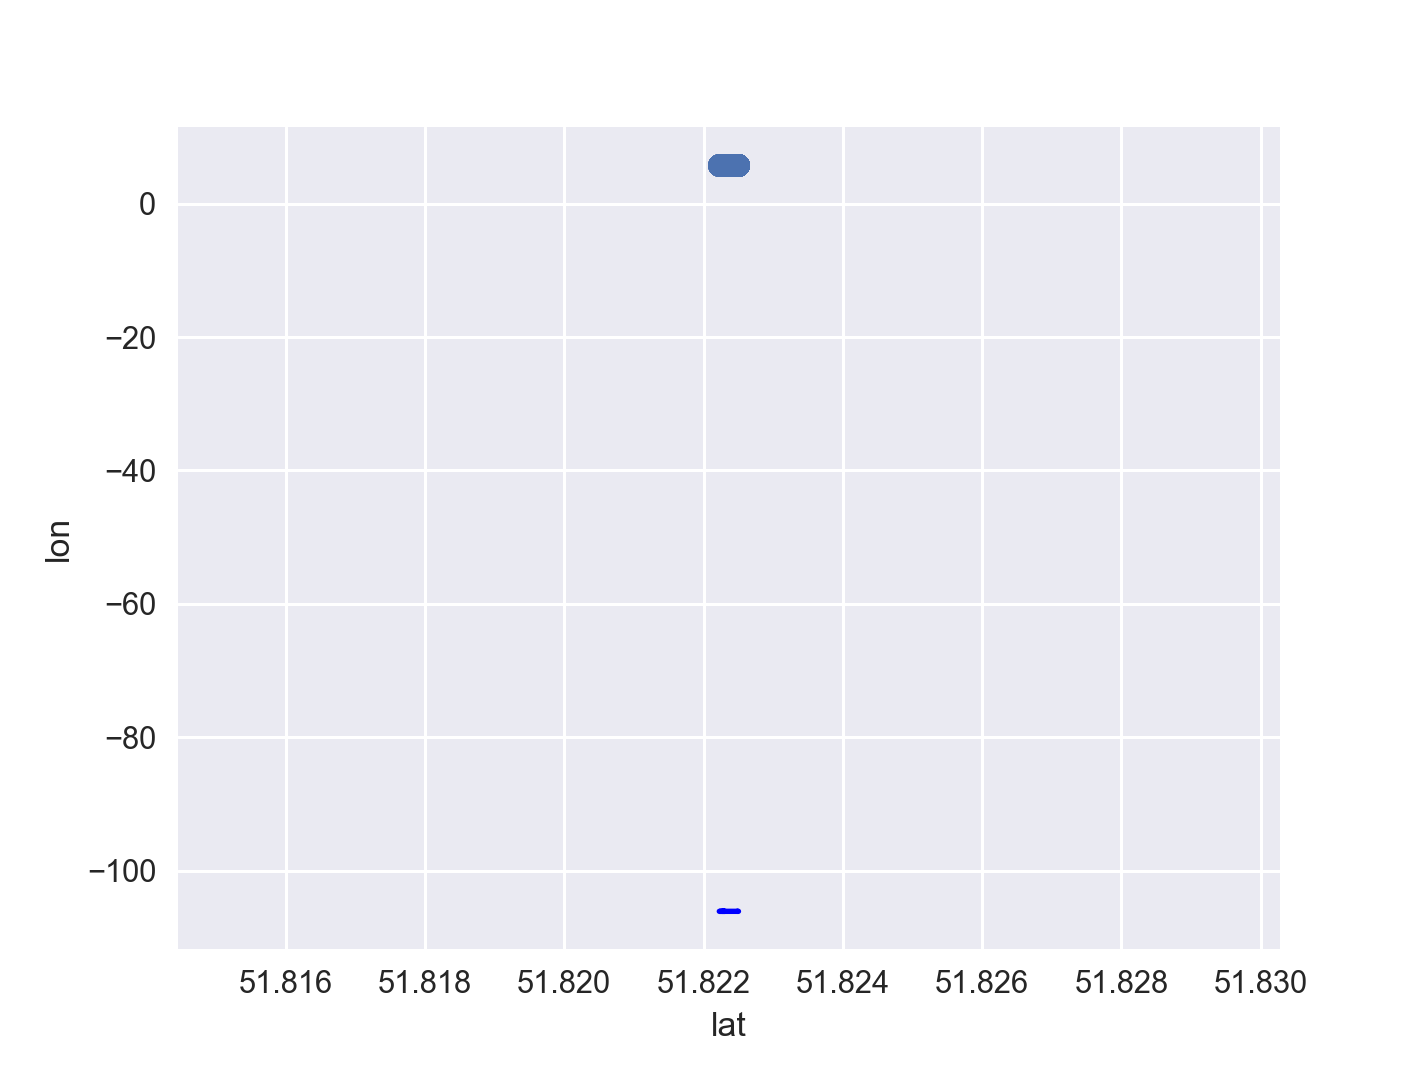

In [413]:
regressie = linereg.predict(y)
plt.scatter(x,y)
plt.plot(x,regressie, color='blue')
plt.xlabel('lat')
plt.ylabel('lon')